## Jupyter notebook to read XRR data and convert to Qx-Qz maps
Reads ".csv" files written by Panalytical XRD system

M.R. Fitzsimmons

Version 1.3

29July2020

30.07.20 Added error propogation and output file writing

03.08.20 Added more sophistication in choice of ROI limits (Border0 and Border1)

03.08.20 Added block to calculate and write specular scattering

03.08.20 Added determinant of the Jacobian of the transformation from real to reciprocal space

04.08.20 Removed extra factor of 2pi/lambda in det(Jac), added a figure of geometry.

06.08.20 Introduced a more complex and hopefully more robust method to identify specular condition in presence of funny background.

07.08.20 Improved robustness of more complex method to correct for misalignment

## Import and function defintions

In [134]:
import os
%cd ~
cwd_path = os.getcwd()
print('Current working directory: %s'%cwd_path)

import re
import numpy as np
from numpy import nan
import scipy.io as sio
import scipy.interpolate as interpolate
from scipy.interpolate import griddata
import scipy.optimize as opt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import matplotlib.colors as colors
import copy

# function obtained from 
# https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
# and modified to return the index (idx) and array value (array[idx]) closes to the target.
def find_nearest(array, target):
    array = np.asarray(array)
    idx = (np.abs(array - target)).argmin()
    return array[idx],idx

# use with curvefit
def curve_line(x,a,b,c,d,e):
    g = np.abs(a + b*x + c*(x-d)**2+e*(x)**3)
    return g

Pi = np.pi

# function used to find location (b) of a Gaussian shaped peak sitting on a linear background.
def gaussian_and_line(x, a, b, c, d, e, f):
    u=np.abs(a)
    v=np.abs(b)
    w=np.abs(c)
    return u*np.exp(-0.5*((x-v)/w)**2) + d + e*x + f*x*x

# function used to find location (b) of a Gaussian shaped peak sitting on a polynomial background.
def gaussian_and_poly(x, a, b, c, d, e, f, g):
    u=np.abs(a)
    v=np.abs(b)
    w=np.abs(c)
    return u*np.exp(-0.5*((x-v)/w)**2) + d + e*x + f*(x-g)**2

# Per Mathematica the determinate of the Jacobian for CW is bivariate depending upon scattering is specular or off-specular
# Derivation done assuming omega is negative angle subtended from surface to transmitted ki
def DetJacobian(WaveLength, Omega, Beta):
    if Beta == 2*np.abs(Omega):
        return 2*Pi/WaveLength*np.cos(Beta/2)
    else:
        return -(2*Pi/WaveLength)**2*np.sin(Beta)



/Users/mf3
Current working directory: /Users/mf3


## USER INPUT required here

Name of '.csv' file of data written by Panalytical.

Opportunity for user to customize ROI limits for background fitting.

In [135]:
DirectoryPath = cwd_path+r'/Dropbox (ORNL)/Project XRR/XRR q-binner/' # USER INPUT HERE
#DirectoryPath = cwd_path+r'/Dropbox (ORNL)/Amanda Huon/' # USER INPUT HERE

NameFile = 'example_data.csv' # USER INPUT HERE
OutputFileBase = DirectoryPath+'example' # USER INPUT HERE
#NameFile = 'sl1.csv' # USER INPUT HERE
#OutputFileBase = DirectoryPath+'sl1_output' # USER INPUT HERE


try:
    InputFile = open(DirectoryPath+NameFile,'r')
    XrayData = InputFile.readlines()
    InputFile.close()
    print('Found data: %s'%NameFile)
except:
    print('No data found: %s'%NameFile)

DoBackSub = True # System default, will subtract background
#DoBackSub = False # Set false to suppress background subtraction
    
UserBorder = False # System default, system will choose ROI. Parameter ignored if DoBackSub is false
#UserBorder = True  # Set to True if you define borders below
if UserBorder:
    Border0, Border1 = 2.75, 3.6  # in degrees defining a border measured from smallest omega up and largest omega down
    
if DoBackSub:
    print('Option: Subtract background.')
    if not UserBorder:
        print('Option: Default ROI limits (tbd).')
    else:
        print('Option: Custom ROI limits chosen: %.2f %.2f (degrees)'%(Border0,Border1))
else:
    print('Option: No background subtraction.')
    
#LinearImage = True # set True for Linear scale
LinearImage = False # set False for Logarithmic scale

if LinearImage:
    print('Option: Plot linear-scale images.')
else:
    print('Option: Plot logarthimic-scale images')

# number of Qx and Qz bins
nQx, nQz = 256,128
#CustomQxQzBins = False # System default to nQx,nQz above
CustomQxQzBins = True # Specify number of Qx and Qz bins below
if CustomQxQzBins:
    nQx,nQz = 512,256 # an example
#    nQx,nQz = 400,103 # an example

print('Option: Number of Qx bins = %s, number of Qz bins = %s'%(nQx,nQz))

# This value executes either the simple or more complex routine for calculating the omega offset
# Try first setting True and if the fitted function is noisy, then try setting False
#SimpleOffset = True # Default
SimpleOffset = False # select this option if the previous one doesn't work well, this one for weak signal in noise
print('Option: SimpleOffset: %s'%SimpleOffset)

print('Output file base: %s'%OutputFileBase)


Found data: example_data.csv
Option: Subtract background.
Option: Default ROI limits (tbd).
Option: Plot logarthimic-scale images
Option: Number of Qx bins = 512, number of Qz bins = 256
Option: SimpleOffset: True
Output file base: /Users/mf3/Dropbox (ORNL)/Project XRR/XRR q-binner/example


## Extract data

Calculate the weighted wavelength in Angstroms.

Record the time per step (leaving opportunity to normalize later).

Obtain axis titles to use later.

The raw data will be counts stored in array "z" with coordinates "x" and "y". Note lower case.

In [136]:
n = len(XrayData)

# get the wavelength
substr1, substr2 = 'K-Alpha1', 'K-Alpha2'
ratio = 0 # ratio of Ka2 to Ka1
for i in range(n):
    if(XrayData[i].find(substr1) == 0):
        kalpha1 = i
    if(XrayData[i].find(substr2) == 0):
        kalpha2 = i
    if(XrayData[i].find(substr1) > 0):
        ratio = i

x=re.findall("\d+\.\d+",XrayData[kalpha1])
kalpha1 = float(x[0])
x=re.findall("\d+\.\d+",XrayData[kalpha2])
kalpha2 = float(x[0])
x=re.findall("\d+\.\d+",XrayData[ratio])
ratio = float(x[0])
WaveLength = (1*kalpha1+ratio*kalpha2)/(1+ratio)

# get the time per step
substr1 = 'Time per step'
for i in range(n):
    if(XrayData[i].find(substr1) == 0):
        TimePerStep = i

x=re.findall("\d+\.\d+",XrayData[TimePerStep])
TimePerStep = float(x[0])

# get Axis titles
substr1 = '[Scan points]'
for i in range(n):
    if(XrayData[i].find(substr1) == 0):
        Trigger = i
s = XrayData[Trigger+1].split(',')
xAxisTitle = s[0]
yAxisTitle = s[1]
r = s[2].split('\n')
zAxisTitle = r[0]

# read the data
m = n - Trigger - 2
x = np.zeros(m, dtype=np.float32) # x will be x axis two_theta in real space plots
y = np.zeros(m, dtype=np.float32) # y will be y axis omega in real space plots
z = np.zeros(m, dtype=np.float32) # z is the count(x,y)
for i in range(m):
    s = XrayData[i+Trigger+2].split(',')
    x[i] = float(s[0])
    y[i] = float(s[1])
    z[i] = float(s[2])


## Plot the raw image of the data

Code to plot an image of the binned data. Number of bins given by the number of unique steps in x (=u) and y (=v). 
The binned counts are stored in "Z" with coordinates "X" and "Y".  Note the upper case.  The raw data are preserved.

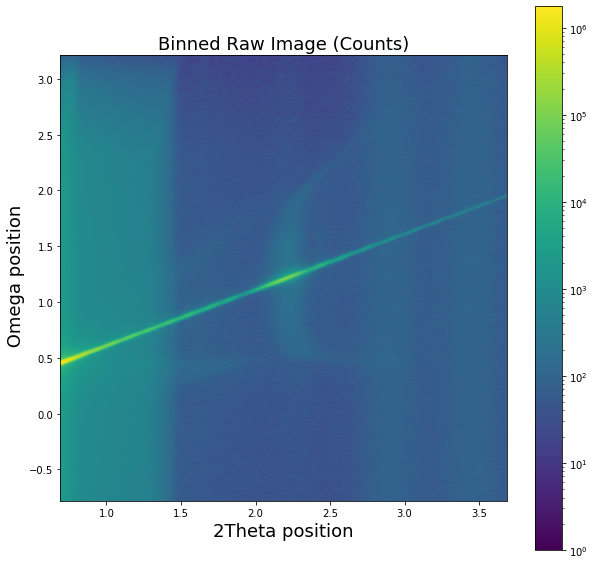

In [137]:
xmin, ymin = np.min(x),np.min(y)
xmax, ymax = np.max(x),np.max(y)
u,v = len(np.unique(x)), len(np.unique(y))
X,Y = np.linspace(xmin,xmax,u), np.linspace(ymin,ymax,v)

Z = np.zeros((u,v), dtype=np.float32) # contains the binned data with coordinates X,Y; the unbinned remain x,y,z
for i in range(m):
    h,k = find_nearest(X,x[i])
    h,l = find_nearest(Y,y[i])
    Z[k,l] = Z[k,l] + z[i]

plt.figure(figsize = (10,10))
plt.xlabel(xAxisTitle,fontsize=18)
plt.ylabel(yAxisTitle,fontsize=18)
plt.title('Binned Raw Image (Counts)',fontsize=18)

if LinearImage:
    vlow, vhi = 0, 0.5*np.max(Z) # SL3_new
#    vlow, vhi = 0, 1.e-0*np.max(Z)
    plt.imshow(np.transpose(Z,axes=[1,0]), extent=[xmin,xmax,ymin,ymax], aspect=(xmax-xmin)/(ymax-ymin), origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=colors.Normalize(vmin=vlow, vmax=vhi))
else:
    vlow, vhi = 1, 1e-0*np.max(Z)
    plt.imshow(np.transpose(Z,axes=[1,0]), extent=[xmin,xmax,ymin,ymax], aspect=(xmax-xmin)/(ymax-ymin), origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=LogNorm(vmin=vlow, vmax=vhi))

plt.colorbar()
plt.show()


## Extract the omega offset
We assume the specular ridge is reasonably defined by where the maximum intensity is in omega for each 2theta value.
These are recorded and fitted to a line, i.e., omega_peak = intercept + slope * 2theta.  The coefficients of the best
fit are obtained. The raw omega coordinate, "y", is changed so that the intercept = 0 and the slope = 0.5. This
ensures when the conversion to Qx-Qz is made later, the specular ridge appears at Qx=0 for all Qz.

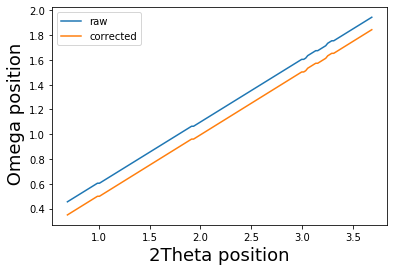

 Omega position offset: 0.107 (should be 0)
 Omega position slope: 0.498 (should be 0.5)


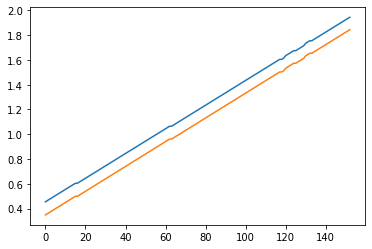

In [138]:
# find the value of omega corresponding to the specular ridge vs. 2theta
s = np.zeros(u, dtype=np.float32)

if not SimpleOffset:
    ua, ub = int(u/2-20+0.5), int(u/2+20+0.5)
    va, vb = int(v/2-v/4+0.5),int(v/2+v/4+0.5)
    idx,idy = np.where(Z==np.max(Z[ua:ub,va:vb])) # find the maximum of the image, presumably along the specular condition
    x0,y0 = int(idx[0]),int(idy[0])

    ua, ub = int(3*u/4-20+0.5), int(3*u/4+20+0.5)
    va, vb =int(v/2+0.5), v-1
    idx,idy = np.where(Z==np.max(Z[ua:ub,va:vb])) # find the maximum of the image, presumably along the specular condition
    x1,y1 = int(idx[0]),int(idy[0])
    slope = (y1-y0)/(x1-x0)
    intercept = y0-slope*x0

for i in range(u):
    if SimpleOffset:
        centroid = np.argmax(Z[i,:])
    else:
        yg = int(slope*i+intercept+0.5)
        llim = np.max([yg-50,0])
        ulim = np.min([yg+50,v-1])
        a = np.max(Z[i,llim:ulim])
        b = yg
        c = 3.
        d = 0
        e = 0.
        f = 0.
        popt, pcov = opt.curve_fit(gaussian_and_line, np.arange(llim,ulim,1), Z[i,llim:ulim], p0=[a,b,c,d,e,f])
        centroid = int(popt[1]+0.5)
    s[i] = Y[centroid]
    
coef = np.polyfit(X,s,1)

plt.xlabel(xAxisTitle,fontsize=18)
plt.ylabel(yAxisTitle,fontsize=18)
plt.plot(X,s,label='raw')
plt.plot(X,0.5*(s-coef[1])/coef[0],label='corrected')
plt.legend(loc='upper left')
plt.show()

plt.plot(s,label='raw')
plt.plot(0.5*(s-coef[1])/coef[0],label='corrected')

print(yAxisTitle+' offset: %.3f (should be 0)'%coef[1])
print(yAxisTitle+' slope: %.3f (should be 0.5)'%coef[0])

y = 0.5*(y-coef[1])/coef[0] + 0 # we assume theta:2theta scan

## Re-evaluate the mesh and plot the offset-corrected image of the data
Having corrected "y", we reapply the code to ensure that the offset is zero and the slope is 0.5.

Finally, we define the variance of "z" as "var_z"

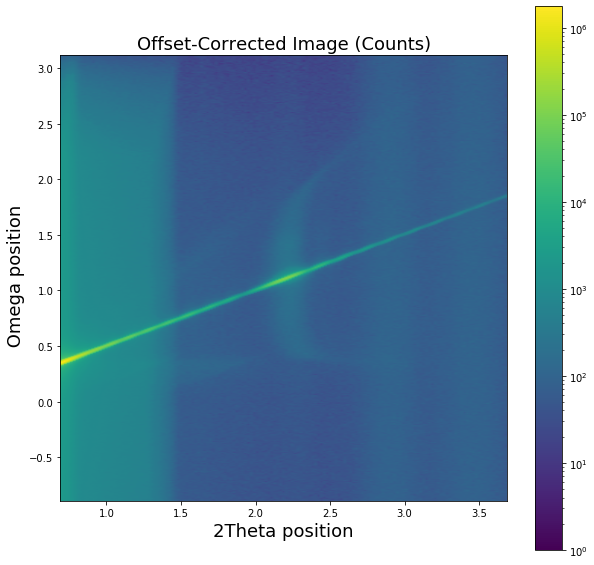

 Omega position offset: -0.000 (should be 0)
 Omega position slope: 0.500 (should be 0.5)


In [139]:
xmin, ymin = np.min(x),np.min(y)
xmax, ymax = np.max(x),np.max(y)
u,v = len(np.unique(x)), len(np.unique(y))
X,Y = np.linspace(xmin,xmax,u), np.linspace(ymin,ymax,v)

Z = np.zeros((u,v), dtype=np.float32)
for i in range(m):
    h,k = find_nearest(X,x[i])
    h,l = find_nearest(Y,y[i])
    Z[k,l] = Z[k,l] + z[i]

plt.figure(figsize = (10,10))
plt.xlabel(xAxisTitle,fontsize=18)
plt.ylabel(yAxisTitle,fontsize=18)
plt.title('Offset-Corrected Image (Counts)',fontsize=18)

if LinearImage:
    vlow, vhi = 0, 0.5*np.max(Z) # SL3_new
#    vlow, vhi = 0, 1.e-0*np.max(Z)
    plt.imshow(np.transpose(Z,axes=[1,0]), extent=[xmin,xmax,ymin,ymax], aspect=(xmax-xmin)/(ymax-ymin), origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=colors.Normalize(vmin=vlow, vmax=vhi))
else:
    vlow, vhi = 1, 1e-0*np.max(Z)
    plt.imshow(np.transpose(Z,axes=[1,0]), extent=[xmin,xmax,ymin,ymax], aspect=(xmax-xmin)/(ymax-ymin), origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=LogNorm(vmin=vlow, vmax=vhi))

plt.colorbar()
plt.show()

# find the value of omega corresponding to the specular ridge vs. 2theta
# verify correction worked
s = np.zeros(u, dtype=np.float32)

if not SimpleOffset:
    ua, ub = int(u/2-20+0.5), int(u/2+20+0.5)
    va, vb = int(v/2-v/4+0.5),int(v/2+v/4+0.5)
    idx,idy = np.where(Z==np.max(Z[ua:ub,va:vb])) # find the maximum of the image, presumably along the specular condition
    x0,y0 = int(idx[0]),int(idy[0])

    ua, ub = int(3*u/4-20+0.5), int(3*u/4+20+0.5)
    va, vb =int(v/2+0.5), v-1
    idx,idy = np.where(Z==np.max(Z[ua:ub,va:vb])) # find the maximum of the image, presumably along the specular condition
    x1,y1 = int(idx[0]),int(idy[0])
    slope = (y1-y0)/(x1-x0)
    intercept = y0-slope*x0

for i in range(u):
    if SimpleOffset:
        centroid = np.argmax(Z[i,:])
    else:
        yg = int(slope*i+intercept+0.5)
        llim = np.max([yg-20,0])
        ulim = np.min([yg+20,v-1])
        a = np.max(Z[i,llim:ulim])
        b = yg
        c = 3.
        d = 0.
        e = 0.
        f = 0.
        popt, pcov = opt.curve_fit(gaussian_and_line, np.arange(llim,ulim,1), Z[i,llim:ulim], p0=[a,b,c,d,e,f])
        centroid = int(popt[1]+0.5)
    s[i] = Y[centroid]
    
coef = np.polyfit(X,s,1)

print(yAxisTitle+' offset: %.3f (should be 0)'%coef[1])
print(yAxisTitle+' slope: %.3f (should be 0.5)'%coef[0])

var_z = copy.deepcopy(z) # the variance is the count
z_net = copy.deepcopy(z) # do this in case user does not wish to subtract background later
var_z_net = copy.deepcopy(z)


## Subtract background

Using the ROI's for the background (region of data outside of the ROI established by Border0 and Border1 in omega), 
the a polynomial of degree 2 is fitted |(a + b*x +c*(x-d)^2)| to the data.  The polynomial yields background in the ROI
and is removed from "z" yielding "z_net" (and the error too).

In [140]:
z_net = copy.deepcopy(z)
var_z_net = copy.deepcopy(var_z)

Background0 = np.zeros(m, dtype=np.float32)

if DoBackSub:
    if not UserBorder:
        Border0, Border1 = np.max([0.1*np.max(y)+np.min(y),0.]), 0.9*np.max(y)  # in degrees defining a border measured from smallest omega up and largest omega down

    print('Limits of ROI: %.2f %.2f (degrees)'%(Border0,Border1))
    
    vmask_lo, vmask_hi = np.min(np.where(y>Border0)), np.max(np.where(y<Border1))

    xr = np.concatenate([x[0:vmask_lo], x[vmask_hi:m-1]])
    yr = np.concatenate([y[0:vmask_lo], y[vmask_hi:m-1]])
    zr = np.concatenate([z[0:vmask_lo], z[vmask_hi:m-1]])

    xUnique = np.unique(x)
    nUnique = len(xUnique)

    for i in range(nUnique):
        idx = np.where(xr == xUnique[i])
        ydata, zdata = yr[idx], zr[idx]
        initial_guesses = [np.mean(zdata),0.,0.,1.,0.]
        popt, pcov = opt.curve_fit(curve_line, ydata, zdata, p0=initial_guesses)
        if i ==20:
            popt_s = popt
            cc = curve_line(ydata,*popt)
        idx = np.where(x == xUnique[i])
        Background = curve_line(y[idx], *popt)
        z_net[idx] = z_net[idx] - Background
        var_z_net[idx] = z_net[idx] + Background
        Background0[idx] = Background

Limits of ROI: 0.00 2.81 (degrees)


## Show background and background subtracted image

Now show an image of what the interpolated background looks like, and an image of the background subtracted data. 

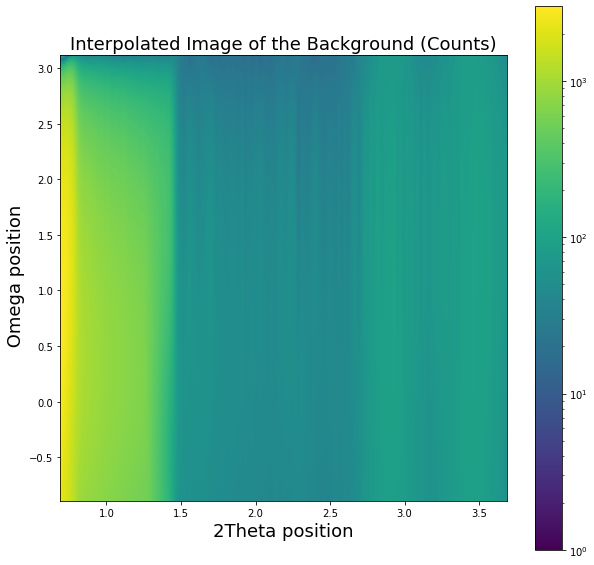

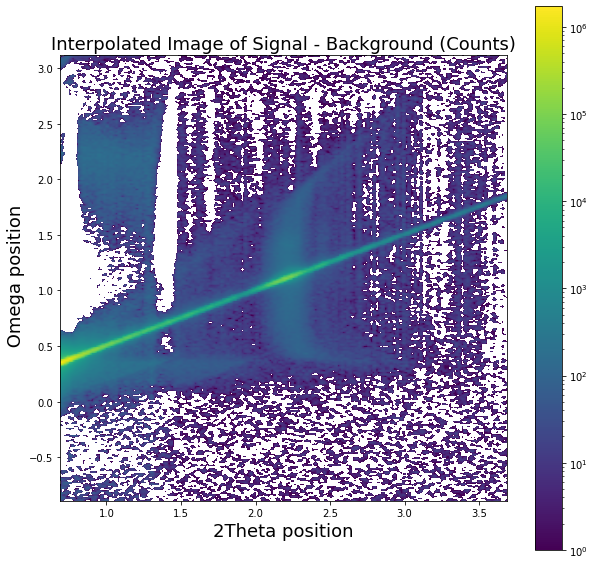

In [141]:
if DoBackSub:
    # an approach to produce an interpolated image of the background
    grid_x, grid_y = np.mgrid[np.min(x):np.max(x):256j,np.min(y):np.max(y):256j]
    points = np.zeros((len(x),2))
    points[:,0] = x
    points[:,1] = y
    grid_z0 = griddata(points, Background0, (grid_x,grid_y), method='linear')
    grid_z0 = np.nan_to_num(grid_z0) # convert NaN to 0

    plt.figure(figsize = (10,10))
    plt.xlabel(xAxisTitle,fontsize=18)
    plt.ylabel(yAxisTitle,fontsize=18)
    plt.title('Interpolated Image of the Background (Counts)',fontsize=18)

    if LinearImage:
        vlow, vhi = 0, 0.5*np.max(grid_z0) # SL3_new
#        vlow, vhi = 0, 1.e-0*np.max(grid_z0)
        plt.imshow(np.transpose(grid_z0,axes=[1,0]), extent=[np.min(x),np.max(x),np.min(y),np.max(y)], aspect=(np.max(x)-np.min(x))/(np.max(y)-np.min(y)), origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=colors.Normalize(vmin=vlow, vmax=vhi))
    else:
        vlow, vhi = 1, 1e-0*np.max(grid_z0)
        plt.imshow(np.transpose(grid_z0,axes=[1,0]), extent=[np.min(x),np.max(x),np.min(y),np.max(y)], aspect=(np.max(x)-np.min(x))/(np.max(y)-np.min(y)), origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=LogNorm(vmin=vlow, vmax=vhi))

    plt.colorbar()
    plt.show()

    # produce interpolated image of signal - background
    grid_z0 = griddata(points, z_net, (grid_x,grid_y), method='linear')
    grid_z0 = np.nan_to_num(grid_z0) # convert NaN to 0

    plt.figure(figsize = (10,10))
    plt.xlabel(xAxisTitle,fontsize=18)
    plt.ylabel(yAxisTitle,fontsize=18)
    plt.title('Interpolated Image of Signal - Background (Counts)',fontsize=18)

    if LinearImage:
        vlow, vhi = 0, 0.1*np.max(grid_z0) # SL3_new
#    vlow, vhi = 0, 1.e-0*np.max(grid_z0)
        plt.imshow(np.transpose(grid_z0,axes=[1,0]), extent=[np.min(x),np.max(x),np.min(y),np.max(y)], aspect=(np.max(x)-np.min(x))/(np.max(y)-np.min(y)), origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=colors.Normalize(vmin=vlow, vmax=vhi))
    else:
        vlow, vhi = 1, 1e-0*np.max(grid_z0)
        plt.imshow(np.transpose(grid_z0,axes=[1,0]), extent=[np.min(x),np.max(x),np.min(y),np.max(y)], aspect=(np.max(x)-np.min(x))/(np.max(y)-np.min(y)), origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=LogNorm(vmin=vlow, vmax=vhi))

    plt.colorbar()
    plt.show()


## From the raw data calculate Qx, Qz
Geometry:
    
    1) Sample surface assumed horizontal.
    
    2) Omega is the angle from surface to the incident wavevector.
    
    3) 2Theta (=Beta) is the angle subtending incident and scattering wavevector.
    
    4) Angles are positive if they rotate in counterclockwise orientation.

![alt text](geometry_diagram.jpg)


In [142]:
# Omega sign from panalytic is opposite to our definitions
# omega is angle measured from surface to transmitted ki and typically negative
phi, two_theta = -y * Pi/180., x * Pi/180.
kix, kiz = 2*Pi/WaveLength*np.cos(phi),           2*Pi/WaveLength*np.sin(phi)
kfx, kfz = 2*Pi/WaveLength*np.cos(two_theta+phi), 2*Pi/WaveLength*np.sin(two_theta+phi)
Qx, Qz = kfx-kix, kfz-kiz  

## Form the Qx-Qz-binned data and plot the images

The Qx-Qz-binned data will be contained in "S" (its variance in "VarS") with coordinates "QX" and "QZ".

The number of Qx bins (=u) and Qz bins (=v) can be changed by the user.

The determinant of the Jacobian of the transformation, "J", records the instances multiple real space elements are
mapped to the same Qx-Qz bin.

Two images are plotted. The first is of the binned data ("S"); the second uses a scipy grid interpolation method operating
directly on "z_net"--the background subtracted unbinned data set.

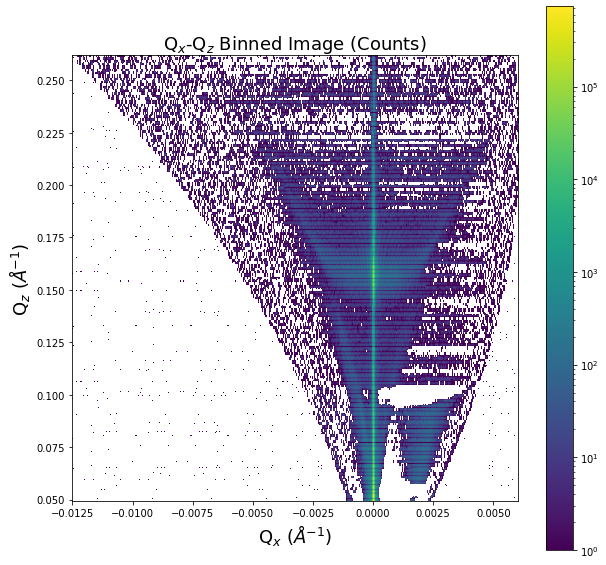

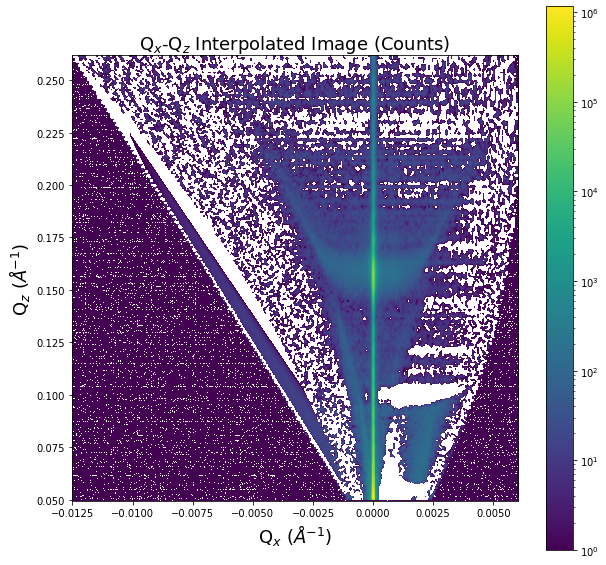

In [143]:
Qxmin, Qzmin = np.min(Qx), np.min(Qz)
Qxmax, Qzmax = np.max(Qx), np.max(Qz)
QX,QZ = np.linspace(Qxmin,Qxmax,nQx), np.linspace(Qzmin,Qzmax,nQz)

S = np.zeros((nQx,nQz), dtype=np.float32)
VarS = np.zeros((nQx,nQz), dtype=np.float32)
for i in range(m):
    h,k = find_nearest(QX,Qx[i])
    h,l = find_nearest(QZ,Qz[i])
    S[k,l] = S[k,l] + z_net[i]*np.abs(DetJacobian(WaveLength,phi[i],two_theta[i]))
    VarS[k,l] = VarS[k,l] + var_z_net[i]*DetJacobian(WaveLength,phi[i],two_theta[i])**2


plt.figure(figsize = (10,10))
plt.xlabel('Q$_x$ ($\AA$$^{-1}$)',fontsize=18)
plt.ylabel('Q$_z$ ($\AA$$^{-1}$)',fontsize=18)
plt.title('Q$_x$-Q$_z$ Binned Image (Counts)',fontsize=18)

if LinearImage:
    vlow, vhi = 0, np.max(S)
    plt.imshow(np.transpose(S,axes=[1,0]), extent=[Qxmin,Qxmax,Qzmin,Qzmax], aspect=(Qxmax-Qxmin)/(Qzmax-Qzmin), origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=colors.Normalize(vmin=vlow, vmax=vhi))
else:
    vlow, vhi = 1, np.max(S)
    plt.imshow(np.transpose(S,axes=[1,0]), extent=[Qxmin,Qxmax,Qzmin,Qzmax], aspect=(Qxmax-Qxmin)/(Qzmax-Qzmin), origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=LogNorm(vmin=vlow, vmax=vhi))

plt.colorbar()
plt.show()

# an approach to produce an interpolated image
grid_QX, grid_QZ = np.mgrid[np.min(QX):np.max(QX):256j,np.min(QZ):np.max(QZ):256j]
points = np.zeros((len(Qx),2))
points[:,0] = Qx
points[:,1] = Qz
grid_z0 = griddata(points, z_net, (grid_QX,grid_QZ), method='linear')
grid_z0 = np.nan_to_num(grid_z0) # convert NaN to 0

plt.figure(figsize = (10,10))
plt.xlabel('Q$_x$ ($\AA$$^{-1}$)',fontsize=18)
plt.ylabel('Q$_z$ ($\AA$$^{-1}$)',fontsize=18)
plt.title('Q$_x$-Q$_z$ Interpolated Image (Counts)',fontsize=18)

if LinearImage:
    vlow, vhi = 0, np.max(grid_z0)
    plt.imshow(np.transpose(grid_z0,axes=[1,0]), extent=[Qxmin,Qxmax,Qzmin,Qzmax], aspect=(Qxmax-Qxmin)/(Qzmax-Qzmin), origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=colors.Normalize(vmin=vlow, vmax=vhi))
else:
    vlow, vhi = 1, np.max(grid_z0)
    plt.imshow(np.transpose(grid_z0,axes=[1,0]), extent=[Qxmin,Qxmax,Qzmin,Qzmax], aspect=(Qxmax-Qxmin)/(Qzmax-Qzmin), origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=LogNorm(vmin=vlow, vmax=vhi))

plt.colorbar()
plt.show()

## Write the results to output files.
Data are written to numpy binary files and to matlab formatted files.

In [144]:
np.savez(OutputFileBase+'.npz',x=x,y=y,z=z,var_z=var_z,z_net=z_net,var_z_net=var_z_net,Qx=Qx,Qz=Qz,QX=QX,QZ=QZ,S=S,VarS=VarS)
sio.savemat(OutputFileBase+'.mat',{'x':x,'y':y,'z':z,'var_z':var_z,'z_net':z_net,'var_z_net':var_z_net,\
                                   'Qx':Qx,'Qz':Qz,'QX':QX,'QZ':QZ,'S':S,'VarS':VarS})

## Plot the specular scattering
Write the results to a text file.

Centroid:	344.88 (fractional pixel) 	4.94E-06 (inverse Angstroms)
RMS_width:	0.45 (fractional pixel) 	1.6410E-05 (inverse Angstroms)
Indices of ROI to integrate over Qx: 343 347
Limits of Qx of ROI to integrate: -6.769E-05 7.757E-05


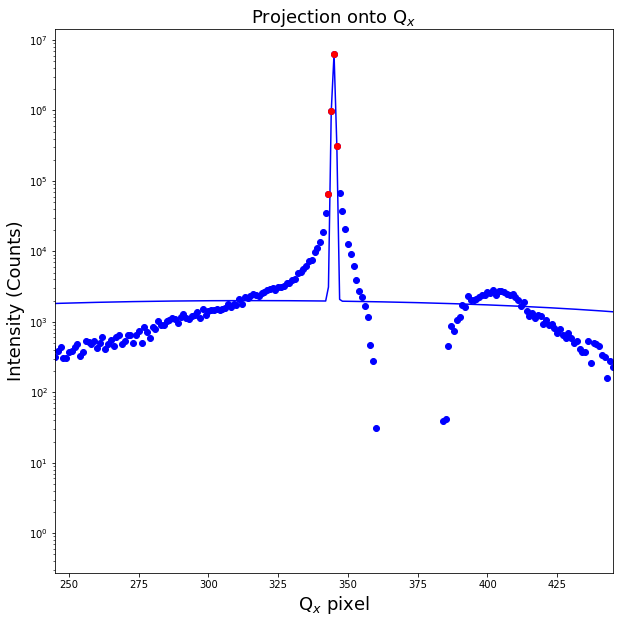

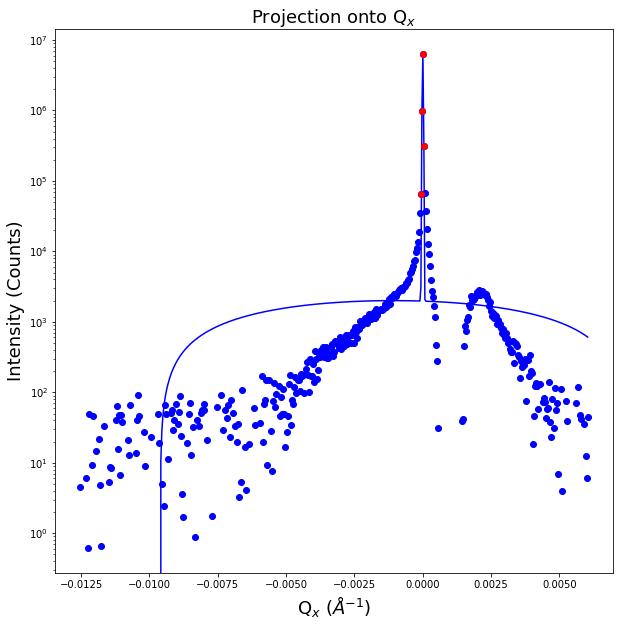

Number of zeros in R(Q): 103 out of: 256
Consider decreasing nQz


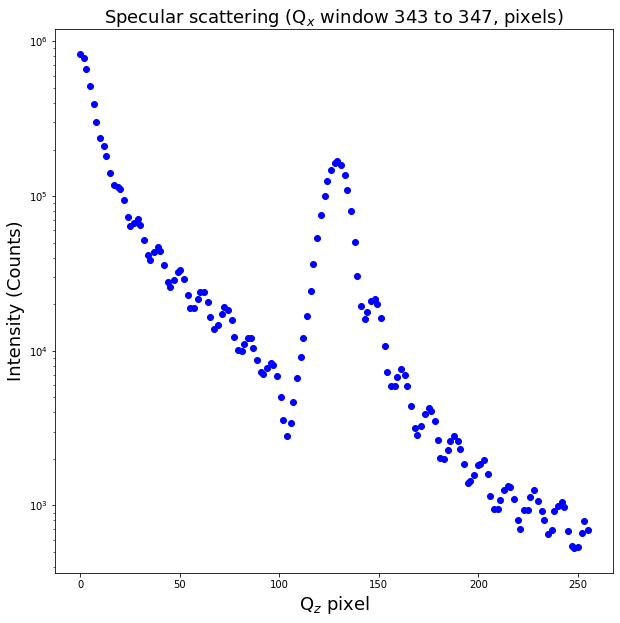

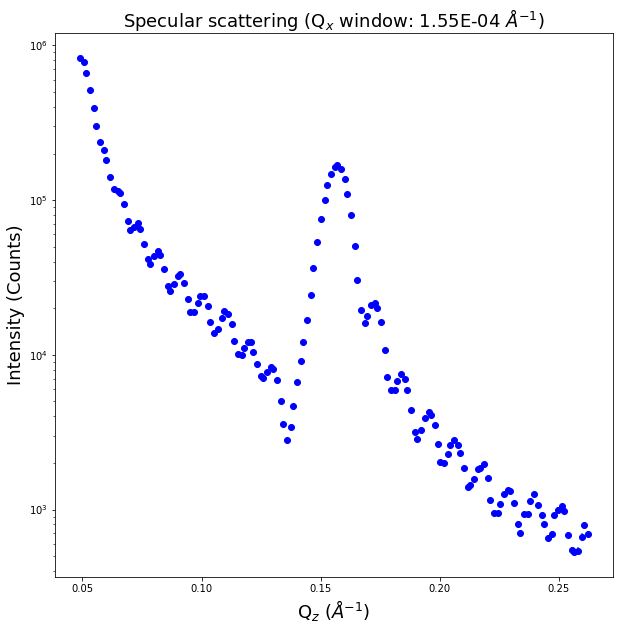

In [145]:
Qxproj = np.sum(S,axis=1)
idx = np.arange(0,nQx)

a=np.amax(Qxproj)
bv,b = find_nearest(Qxproj,a)
c=5.
d = 0.
e = 0.
f = 0.
g = nQx/2.
popt, pcov = opt.curve_fit(gaussian_and_poly, idx, Qxproj, p0=[a,b,c,d,e,f,g])

centroid, rms_width = popt[1], popt[2]
Qx_idx = int(centroid+0.5)

print('Centroid:\t%.2f (fractional pixel) \t%.2E (inverse Angstroms)'%(centroid,QX[Qx_idx]))
print('RMS_width:\t%.2f (fractional pixel) \t%.4E (inverse Angstroms)'%(rms_width,rms_width*(Qxmax-Qxmin)/nQx))

RoiLo, RoiHi = Qx_idx-int(rms_width*5+0.5),Qx_idx+int(rms_width*5+0.5)
QxDelta = np.max(np.abs([QX[RoiLo],QX[RoiHi]]))

h, RoiLo = find_nearest(QX,-QxDelta)
h, RoiHi = find_nearest(QX, QxDelta)

print('Indices of ROI to integrate over Qx: %s %s'%(RoiLo,RoiHi))
print('Limits of Qx of ROI to integrate: %.3E %.3E'%(QX[RoiLo],QX[RoiHi]))

plt.figure(figsize = (10,10))
plt.xlim(np.max([Qx_idx-100,0]),np.min([Qx_idx+100,nQx]))
plt.xlabel('Q$_x$ pixel',fontsize=18)
plt.ylabel('Intensity (Counts)',fontsize=18)
plt.yscale('log')
plt.title('Projection onto Q$_x$',fontsize=18)
plt.plot(idx,Qxproj,'bo')
plt.plot(idx,gaussian_and_poly(idx, *popt),'b-')
plt.plot(np.arange(RoiLo,RoiHi),Qxproj[RoiLo:RoiHi],'ro')
plt.show()

plt.figure(figsize = (10,10))
plt.xlabel('Q$_x$ ($\AA$$^{-1}$)',fontsize=18)
plt.ylabel('Intensity (Counts)',fontsize=18)
plt.yscale('log')
plt.title('Projection onto Q$_x$',fontsize=18)
plt.plot(QX[idx],Qxproj,'bo')
plt.plot(QX[idx],gaussian_and_poly(idx, *popt),'b-')
plt.plot(QX[np.arange(RoiLo,RoiHi)],Qxproj[RoiLo:RoiHi],'ro')
plt.show()

RofQz = np.sum(S[RoiLo:RoiHi,:],axis=0)
VarRofQz = np.sum(VarS[RoiLo:RoiHi,:],axis=0)

nzeros = nQz-np.count_nonzero(RofQz)
print('Number of zeros in R(Q): %s out of: %s'%(nzeros,nQz))
if nzeros > 0:
    print('Consider decreasing nQz')

plt.figure(figsize = (10,10))
plt.xlabel('Q$_z$ pixel',fontsize=18)
plt.ylabel('Intensity (Counts)',fontsize=18)
plt.yscale('log')
plt.title('Specular scattering (Q$_x$ window %s to %s, pixels)'%(RoiLo,RoiHi),fontsize=18)
plt.plot(RofQz,'bo')
plt.show()

plt.figure(figsize = (10,10))
plt.xlabel('Q$_z$ ($\AA$$^{-1}$)',fontsize=18)
plt.ylabel('Intensity (Counts)',fontsize=18)
plt.yscale('log')
plt.title('Specular scattering (Q$_x$ window: %.2E $\AA$$^{-1}$)'%(2*QxDelta),fontsize=18)
plt.plot(QZ,RofQz,'bo')
plt.errorbar(QZ,RofQz,np.sqrt(VarRofQz),fmt='none')
plt.show()

file1 = open(OutputFileBase+'.txt','w')
for i in range(nQz):
    if RofQz[i] > 0:
        file1.write('%14.7e %14.7e %14.7e\n'%(QZ[i],RofQz[i],np.sqrt(VarRofQz[i])))
file1.close()


## Plot a Qx cut for fixed Qz
Examples of plots showing a cut across Qx for fixed Qz.

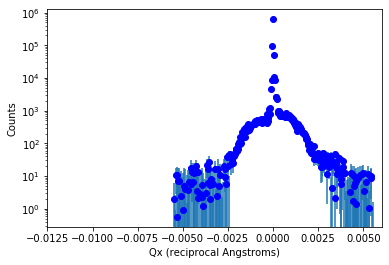

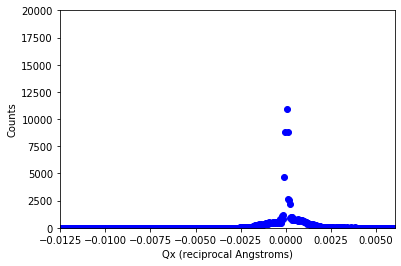

In [146]:
# An example picked from RofQz shown in the Qz pixel plot

PixelCenter, PixelWidth = 125, 5 # set as desired.

# Qx limits to plot
QxLo, QxHi = np.min(Qx), np.max(Qx)

sqx = np.sum(S[:,PixelCenter-PixelWidth:PixelCenter+PixelWidth],axis=1) # the indices of 60:70 encompass the superlattice reflection for the example data.
var_sqx = np.sum(VarS[:,PixelCenter-PixelWidth:PixelCenter+PixelWidth],axis=1)
rms_sqx = np.sqrt(var_sqx)

plt.xlabel('Qx (reciprocal Angstroms)')
plt.ylabel('Counts')
plt.yscale('log')
plt.xlim((QxLo,QxHi))
plt.plot(QX,sqx,'bo')
plt.errorbar(QX,sqx,rms_sqx,fmt='none')
plt.show()

plt.xlabel('Qx (reciprocal Angstroms)')
plt.ylabel('Counts')
plt.yscale('linear')
plt.ylim((0,20000)) # set hi limit for top of scale desired.
plt.xlim((QxLo,QxHi))
plt.plot(QX,sqx,'bo')
plt.errorbar(QX,sqx,rms_sqx,fmt='none')
plt.show()
